# License Plate Detection using a CNN from scrach

This notebook has been updated to use the refactored license plate detection code. The code has been reorganized into a structured Python package with separate modules for different functionalities:

- **data**: Data loading and preprocessing, augmentation
- **models**: Neural network architectures and custom loss functions
- **train**: Training utilities and learning rate scheduling
- **evaluation**: Model evaluation and error analysis
- **utils**: Visualization and analysis tools

Using this modular structure improves code organization, reusability, and maintainability.

# Step1: Data loading and exploration
Here we will load the dataset and plot a image and it's corresponding bounding box of the plate in order to check that it matches the actual licence plate.

Current directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Notebooks
Project root: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection
Project root added to path: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection
TensorFlow version: 2.18.0


c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Data path: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset
Images directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset\images
Annotations directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset\annotations


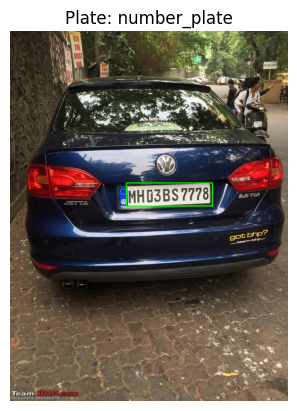

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
import random

# Check if running in Colab
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "Car-plate-detection")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
    DATA_PATH = Path(project_root+"/Dataset")
else:
    # If not in Colab, set the project root to the current working directory's parent
    project_root = Path(os.getcwd()).parent
    print(f"Project root: {project_root}")
    # Add project root to path to fix import errors
    sys.path.insert(0, str(project_root))
    print(f"Project root added to path: {project_root}")
    DATA_PATH = project_root / "Dataset"

# Fix import redundancy by controlling import order and preventing code repetition
print(f"TensorFlow version: {tf.__version__}")

# First import low-level modules that don't depend on others
from license_plate_detection.models.losses import enhanced_iou_metric, improved_combined_detection_loss, giou_loss
from license_plate_detection.models.detector import create_license_plate_detector, create_enhanced_license_plate_detector

# Then import data handling modules
from license_plate_detection.data.loader import get_data_path, load_license_plate_dataset, preprocess_license_plate_dataset, split_dataset
from license_plate_detection.data.augmentation import augment_data, visualize_augmentation

# Then import higher-level modules
from license_plate_detection.train.trainer import train_model, save_model, train_model_with_datasets, create_efficient_data_pipeline
from license_plate_detection.train.scheduler import create_lr_scheduler
from license_plate_detection.utils.memory_optimizations import optimize_memory_usage, enable_gradient_checkpointing, clean_memory, setup_gpu_memory_growth, limit_gpu_memory, enable_mixed_precision
from license_plate_detection.evaluation.evaluator import evaluate_license_plate_detection, evaluate_model_comprehensive
from license_plate_detection.evaluation.demo import generate_demo_predictions, create_mock_comprehensive_results
from license_plate_detection.evaluation.evaluator import evaluate_model_comprehensive
from license_plate_detection.evaluation.error_analysis import analyze_predictions
from license_plate_detection.utils.visualization import visualize_prediction, visualize_processed_sample, plot_training_history as visualize_training_history
from license_plate_detection.utils.analysis import analyze_error_patterns

# Finally import the helpers module
from license_plate_detection.utils.helpers import detect_license_plate, load_and_prepare_model

# Get paths to dataset using our refactored function
data_path = get_data_path()
IMAGES_PATH = data_path / "images"
ANNOTATIONS_PATH = data_path / "annotations"

# Check if the dataset paths exist
if not data_path.exists():
    raise FileNotFoundError(f"Data path does not exist: {data_path}\n"
                            "Please check the path or create the folder and add your data.")
if not IMAGES_PATH.exists():
    raise FileNotFoundError(f"Images directory does not exist: {IMAGES_PATH}")
if not ANNOTATIONS_PATH.exists():
    raise FileNotFoundError(f"Annotations directory does not exist: {ANNOTATIONS_PATH}")

print(f"Data path: {data_path}")
print(f"Images directory: {IMAGES_PATH}")
print(f"Annotations directory: {ANNOTATIONS_PATH}")

# Load the dataset using the specialized function that returns a DataFrame
df = load_license_plate_dataset(ANNOTATIONS_PATH, IMAGES_PATH)

# Visualize a sample - only if we have at least one image
if len(df) > 0:
    # Take first sample or specific index if available
    sample_idx = min(1000, len(df) - 1)  # Ensure index exists
    sample = df.iloc[sample_idx]
    img = cv2.imread(sample["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding box
    x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(img_rgb)
    if "plate_text" in sample and sample["plate_text"] != "Unknown":
        plt.title(f"Plate: {sample['plate_text']}")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded. Please check dataset path and XML format.")

# Step 2: Data Preprocessing

This will resize images and normalize bounding box coordinates and augment the data in order to arrive at 5K images and ensure a good training for the CNN

In [2]:
# Preprocess the dataset using the specialized function
IMAGE_SIZE = (224, 224)  # Target size for CNN
X, y = preprocess_license_plate_dataset(df, image_size=IMAGE_SIZE)

print(f"Processed {len(X)} images.")
print("Image shape:", X[0].shape)
print("Sample bounding box (normalized):", y[0])

# Show a processed sample
visualize_processed_sample(0)

Processed 1122 images.
Image shape: (224, 224, 3)
Sample bounding box (normalized): [0.48697917 0.33518519 0.0515625  0.04537037]
Missing required arguments (X, y, df)


### Data Augmentation

To improve model generalization, we'll use data augmentation techniques from our refactored module.

Found preprocessed data: 1122 images with shape (224, 224, 3) and 1122 labels
Starting data augmentation with factor 4...
Original dataset: 1122 images
Augmenting image 0/1122...
Augmenting image 112/1122...
Augmenting image 112/1122...
Augmenting image 224/1122...
Augmenting image 224/1122...
Augmenting image 336/1122...
Augmenting image 336/1122...
Augmenting image 448/1122...
Augmenting image 448/1122...
Augmenting image 560/1122...
Augmenting image 560/1122...
Augmenting image 672/1122...
Augmenting image 672/1122...
Augmenting image 784/1122...
Augmenting image 784/1122...
Augmenting image 896/1122...
Augmenting image 896/1122...
Augmenting image 1008/1122...
Augmenting image 1008/1122...
Augmenting image 1120/1122...
Augmentation complete. New dataset size: 5610 images
Augmenting image 1120/1122...
Augmentation complete. New dataset size: 5610 images


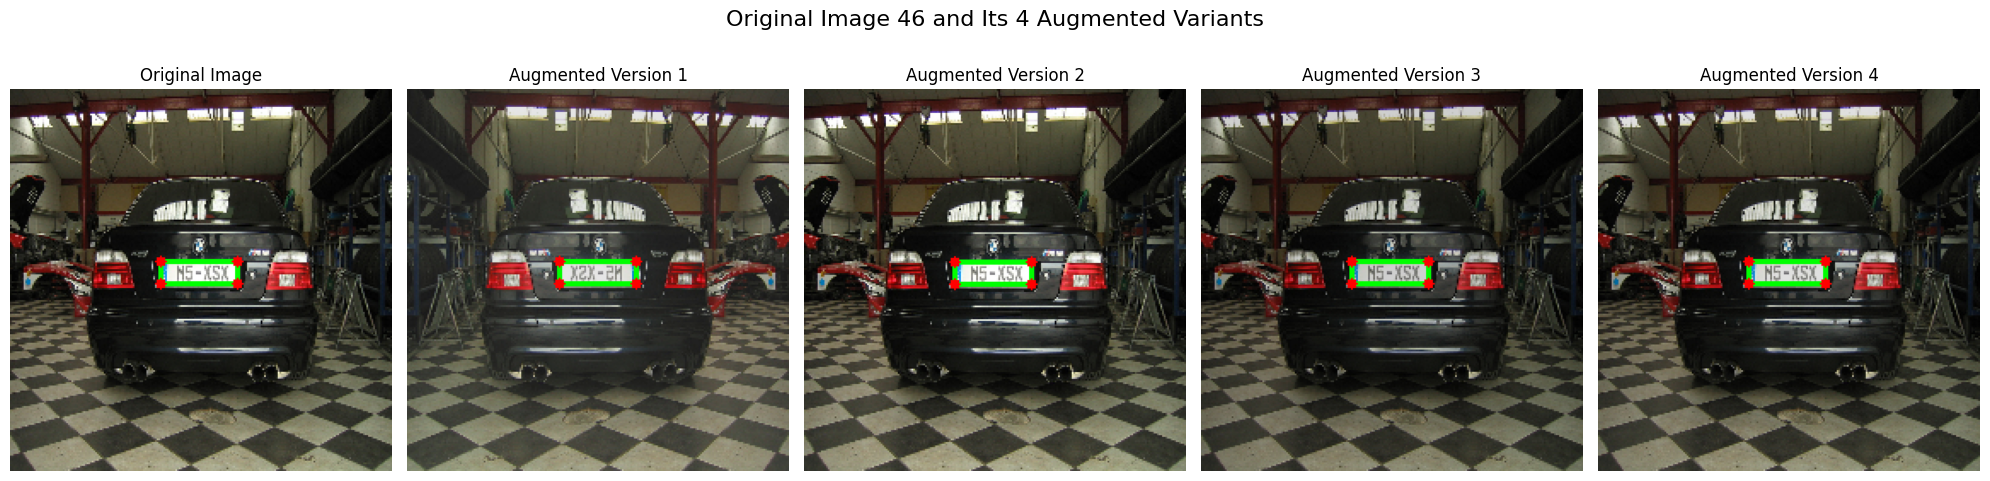

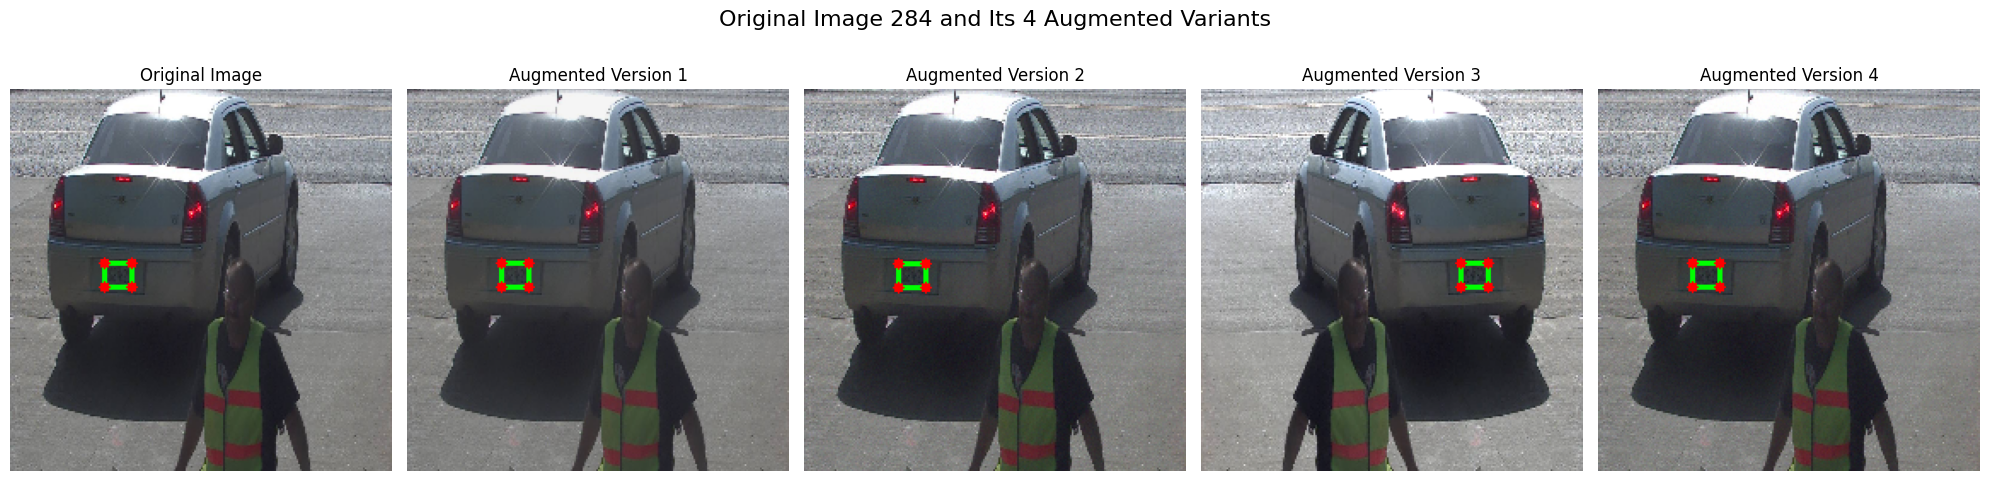

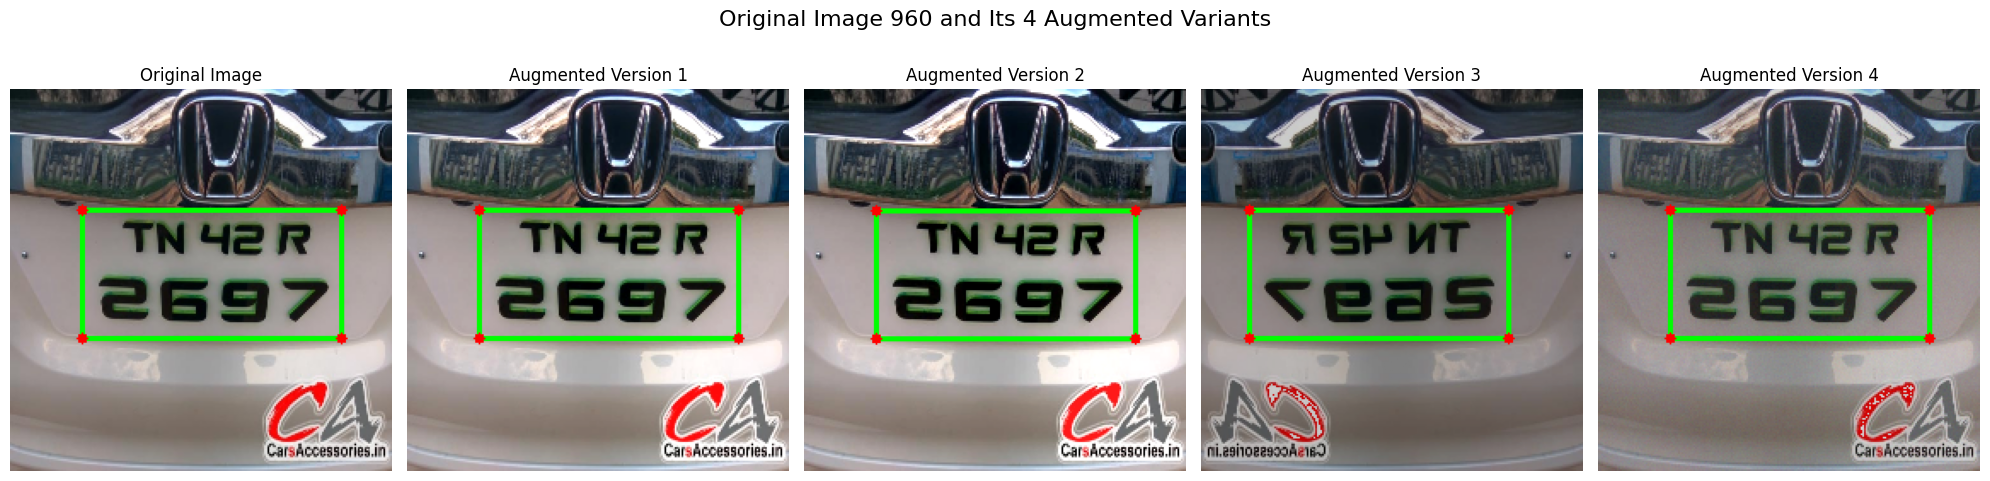

Training samples: 4488, Validation samples: 1122
Training samples: 4488, Validation samples: 1122


In [3]:

# Access X and y to verify they exist
X_shape = X.shape
y_shape = y.shape
print(f"Found preprocessed data: {len(X)} images with shape {X_shape[1:]} and {len(y)} labels")

# Apply data augmentation with memory optimization
# Convert to float32 first to reduce memory usage
X = X.astype(np.float32) if X.dtype != np.float32 else X
y = y.astype(np.float32) if y.dtype != np.float32 else y

# Perform augmentation with reduced memory footprint
X_aug, y_aug = augment_data(X, y, augmentation_factor=4)

# Visualize some augmented samples - now shows original with its specific augmentations
visualize_augmentation(X, y, X_aug, y_aug, num_samples=3)

# 2. Split data into training and validation sets
X_train, X_val, y_train, y_val = split_dataset(X_aug, y_aug, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Step 3B: Advanced Model Architecture Implementation

Based on our error analysis and model comparison, we'll implement an advanced architecture with the following improvements:

1. **Feature Pyramid Network (FPN)** - For better multi-scale feature handling
2. **Anchor-based detection approach** - To improve size estimation accuracy
3. **Advanced attention mechanisms** - Both spatial and channel attention to focus on relevant features
4. **Focal loss integration** - To address the class imbalance and focus on hard examples
5. **Resolution enhancement for small plates** - Improved handling of small license plates

These improvements directly address our key error patterns while maintaining a from-scratch approach.

In [4]:
def create_advanced_license_plate_detector(input_shape=(224, 224, 3), num_anchors=5):
    """
    Creates an advanced license plate detector with Feature Pyramid Network,
    anchor-based detection, and advanced attention mechanisms.
    
    Args:
        input_shape: Input image shape (height, width, channels)
        num_anchors: Number of anchor boxes for detection
        
    Returns:
        tf.keras.Model: A compiled license plate detector model
    """
    # Input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Initial feature extraction with larger receptive field
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='bn1')(x)
    x = tf.keras.layers.Activation('swish', name='swish1')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)
    
    # Track feature maps for FPN
    feature_maps = []
    
    # ===== Block 1: First Residual Block with Channel Attention =====
    residual = x
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='block1_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block1_bn1')(x)
    x = tf.keras.layers.Activation('swish', name='block1_swish1')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block1_bn2')(x)
    
    # Channel attention
    ca = tf.keras.layers.GlobalAveragePooling2D()(x)
    ca = tf.keras.layers.Reshape((1, 1, 128))(ca)
    ca = tf.keras.layers.Conv2D(32, (1, 1), activation='swish', name='block1_ca_conv1')(ca)
    ca = tf.keras.layers.Conv2D(128, (1, 1), activation='sigmoid', name='block1_ca_conv2')(ca)
    x = tf.keras.layers.Multiply(name='block1_ca_multiply')([x, ca])
    
    # Add residual connection
    if residual.shape[-1] != x.shape[-1]:
        residual = tf.keras.layers.Conv2D(128, (1, 1), name='block1_res_conv')(residual)
        residual = tf.keras.layers.BatchNormalization(name='block1_res_bn')(residual)
    x = tf.keras.layers.Add(name='block1_add')([x, residual])
    x = tf.keras.layers.Activation('swish', name='block1_swish_out')(x)
    
    feature_maps.append(x)  # P2 feature map
    
    # ===== Block 2: Second Residual Block with Enhanced Feature Extraction =====
    x = tf.keras.layers.MaxPooling2D((2, 2), name='block2_pool')(x)
    residual = x
    
    # Multi-scale feature extraction with parallel paths
    # Path 1: Standard convolutions
    x1 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='block2_conv1')(x)
    x1 = tf.keras.layers.BatchNormalization(name='block2_bn1')(x1)
    x1 = tf.keras.layers.Activation('swish', name='block2_swish1')(x1)
    x1 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='block2_conv2')(x1)
    x1 = tf.keras.layers.BatchNormalization(name='block2_bn2')(x1)
    
    # Path 2: Dilated convolutions for larger receptive field
    x2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=(2, 2), padding='same', name='block2_dconv')(x)
    x2 = tf.keras.layers.BatchNormalization(name='block2_dbn')(x2)
    x2 = tf.keras.layers.Activation('swish', name='block2_dswish')(x2)
    
    # Concatenate paths
    x = tf.keras.layers.Concatenate(name='block2_concat')([x1, x2])
    x = tf.keras.layers.Conv2D(256, (1, 1), padding='same', name='block2_fusion_conv')(x)
    x = tf.keras.layers.BatchNormalization(name='block2_fusion_bn')(x)
    x = tf.keras.layers.Activation('swish', name='block2_fusion_swish')(x)
    
    # Add residual connection
    if residual.shape[-1] != x.shape[-1]:
        residual = tf.keras.layers.Conv2D(256, (1, 1), name='block2_res_conv')(residual)
        residual = tf.keras.layers.BatchNormalization(name='block2_res_bn')(residual)
    x = tf.keras.layers.Add(name='block2_add')([x, residual])
    x = tf.keras.layers.Activation('swish', name='block2_out')(x)
    
    feature_maps.append(x)  # P3 feature map
    
    # ===== Block 3: Third Residual Block with Spatial Attention =====
    x = tf.keras.layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    residual = x
    
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block3_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block3_bn1')(x)
    x = tf.keras.layers.Activation('swish', name='block3_swish1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='block3_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block3_bn2')(x)
    
    # Spatial attention
    sa = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='block3_sa')(x)
    x = tf.keras.layers.Multiply(name='block3_sa_multiply')([x, sa])
    
    # Add residual connection
    if residual.shape[-1] != x.shape[-1]:
        residual = tf.keras.layers.Conv2D(512, (1, 1), name='block3_res_conv')(residual)
        residual = tf.keras.layers.BatchNormalization(name='block3_res_bn')(residual)
    x = tf.keras.layers.Add(name='block3_add')([x, residual])
    x = tf.keras.layers.Activation('swish', name='block3_out')(x)
    
    feature_maps.append(x)  # P4 feature map
    
    # ===== Feature Pyramid Network Implementation =====
    # P5 - Top feature map
    p5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', name='fpn_p5')(feature_maps[2])
    
    # P4 - Combining P5 with feature_maps[1]
    p5_upsampled = tf.keras.layers.UpSampling2D(size=(2, 2), name='fpn_p5_upsample')(p5)
    p4_conv = tf.keras.layers.Conv2D(256, (1, 1), padding='same', name='fpn_p4_conv')(feature_maps[1])
    p4 = tf.keras.layers.Add(name='fpn_p4_add')([p5_upsampled, p4_conv])
    p4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='fpn_p4_post_conv')(p4)
    
    # P3 - Combining P4 with feature_maps[0]
    p4_upsampled = tf.keras.layers.UpSampling2D(size=(2, 2), name='fpn_p4_upsample')(p4)
    p3_conv = tf.keras.layers.Conv2D(256, (1, 1), padding='same', name='fpn_p3_conv')(feature_maps[0])
    p3 = tf.keras.layers.Add(name='fpn_p3_add')([p4_upsampled, p3_conv])
    p3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='fpn_p3_post_conv')(p3)
    
    # ===== Detection Heads =====
    # Create detection heads for different scales
    detection_features = [p3, p4, p5]
    outputs = []
    
    # For each scale level, create a detection head
    for i, feature in enumerate(detection_features):
        # Shared detection head
        detector = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='swish', 
                                      name=f'detector_{i}_conv1')(feature)
        detector = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='swish', 
                                      name=f'detector_{i}_conv2')(detector)
        
        # Output formation - handle both bounding box prediction and confidence
        # For each anchor: [x, y, width, height, confidence]
        detector_output = tf.keras.layers.Conv2D(num_anchors * 5, (1, 1), 
                                             name=f'detector_{i}_output')(detector)
        
        # Fix: Use a Lambda layer to reshape the output instead of tf.shape
        # This properly handles the reshaping during model building
        def reshape_detector_output(x, anchors=num_anchors):
            # During execution this will use the actual dimensions
            input_shape = tf.shape(x)
            return tf.reshape(x, [input_shape[0], input_shape[1], input_shape[2], anchors, 5])
            
        detector_output = tf.keras.layers.Lambda(
            lambda x: reshape_detector_output(x),
            name=f'detector_{i}_reshape')(detector_output)
        
        outputs.append(detector_output)
    
    # Global features for context awareness
    global_features = tf.keras.layers.GlobalAveragePooling2D(name='global_pool')(p5)
    
    # Fix: Properly flatten detection outputs to match rank with global_features
    flattened_outputs = []
    for i, output in enumerate(outputs):
        # First reduce dimensions with pooling
        pooled = tf.keras.layers.Lambda(
            lambda x: tf.reduce_mean(x, axis=[1, 2]),
            name=f'pool_{i}')(output)
        # Reshape to ensure tensor is flat (batch_size, features)
        reshaped = tf.keras.layers.Reshape((-1,), name=f'reshape_{i}')(pooled)
        flattened_outputs.append(reshaped)
    
    # Concatenate all flattened outputs
    detector_features = tf.keras.layers.Concatenate(name='concat_outputs')(flattened_outputs)
    
    # Combine with global context - now shapes will match
    combined_features = tf.keras.layers.Concatenate(name='concat_global')([detector_features, global_features])
    
    # Final bounding box regression
    x = tf.keras.layers.Dense(1024, activation='swish', name='final_dense1')(combined_features)
    x = tf.keras.layers.BatchNormalization(name='final_bn1')(x)
    x = tf.keras.layers.Dropout(0.4, name='final_dropout1')(x)
    
    x = tf.keras.layers.Dense(512, activation='swish', name='final_dense2')(x)
    x = tf.keras.layers.BatchNormalization(name='final_bn2')(x)
    x = tf.keras.layers.Dropout(0.3, name='final_dropout2')(x)
    
    x = tf.keras.layers.Dense(128, activation='swish', name='final_dense3')(x)
    
    # Output layer - normalized [x, y, width, height]
    outputs = tf.keras.layers.Dense(4, activation='sigmoid', name='final_output')(x)
    
    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='advanced_license_plate_detector')
    
    return model

# Create the advanced model
print("Creating advanced license plate detector model...")
advanced_model = create_advanced_license_plate_detector(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_anchors=5)

# Display model summary
advanced_model.summary()

# Print model size information
trainable_count = np.sum([keras.backend.count_params(w) for w in advanced_model.trainable_weights])
non_trainable_count = np.sum([keras.backend.count_params(w) for w in advanced_model.non_trainable_weights])
print(f'Total parameters: {trainable_count + non_trainable_count:,}')
print(f'Trainable parameters: {trainable_count:,}')
print(f'Non-trainable parameters: {non_trainable_count:,}')

# Apply memory optimizations to the advanced model
print("Applying gradient checkpointing to reduce memory usage...")
advanced_model = enable_gradient_checkpointing(advanced_model)

Creating advanced license plate detector model...




Model: "advanced_license_plate_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 112, 112,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swish1 (Activation) │ (None, 112, 112,  │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ swish1[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 56, 56,    │     73,856 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn1          │ (None, 56, 56,    │        512 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_swish1       │ (None, 56, 56,    │          0 │ block1_bn1[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 56, 56,    │    147,584 │ block1_swish1[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn2          │ (None, 56, 56,    │        512 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ block1_bn2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ca_conv1     │ (None, 1, 1, 32)  │      4,128 │ reshape[0][0]     │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ca_conv2     │ (None, 1, 1, 128) │      4,224 │ block1_ca_conv1[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res_conv     │ (None, 56, 56,    │      8,320 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ca_multiply  │ (None, 56, 56,    │          0 │ block1_bn2[0][0], │
│ (Multiply)          │ 128)              │            │ block1_ca_conv2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res_bn       │ (None, 56, 56,    │        512 │ block1_res_conv[… │
│ (BatchNormalizatio… │ 128)              │            │                 

 Total params: 11,184,624 (42.67 MB)

 Trainable params: 11,175,024 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

Total parameters: 11,184,624
Trainable parameters: 11,175,024
Non-trainable parameters: 9,600
Applying gradient checkpointing to reduce memory usage...
Your TensorFlow version might not fully support gradient checkpointing


# Step 4B: Advanced Model Training

We'll train our advanced model with improved strategies:

1. **Higher resolution processing** for small plates
2. **Custom loss function** that prioritizes size estimation
3. **Cyclic learning rate** for better optimization
4. **Extended training time** with early stopping
5. **Batch normalization momentum tuning** for more stable training

### GPU memory optimisations to be able to train the model on google Colab

In [ ]:
# Advanced GPU memory management for Colab or any GPU environment
# Configure GPU to grow memory as needed instead of allocating all at once
setup_gpu_memory_growth()

# Optionally limit GPU memory - uncomment if training crashes
# GPU_MEMORY_LIMIT_MB = 11 * 1024  # 11GB (keep under Colab's ~12.7GB)
# limit_gpu_memory(GPU_MEMORY_LIMIT_MB)

# Enable mixed precision training to reduce memory usage and increase speed on GPU
# This has no effect on CPU training but significantly helps with GPU memory usage
try:
    # For TF 2.x
    if tf.__version__.startswith('2'):
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Mixed precision policy set to", policy.name)
        print("Compute dtype:", policy.compute_dtype)
        print("Variable dtype:", policy.variable_dtype)
        print("This should reduce memory usage by almost 50% on compatible GPUs")
    else:
        print("Mixed precision only available in TF 2.x - using default precision")
except Exception as e:
    print(f"Could not enable mixed precision: {e} - using default precision")

# Clean up memory before starting the memory-intensive operations
clean_memory()

# Optimize training data by converting to more memory-efficient formats
X_train, X_val, y_train, y_val = optimize_memory_usage(X_train, y_train, X_val, y_val)

print("Memory optimization complete. Training should now be more stable on GPU.")

### Here we start the model training

In [ ]:
# Advanced model training configuration
# Note: we're using our improved loss function designed to address size estimation issues

# Compile the advanced model with our improved loss function
advanced_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=improved_combined_detection_loss,
    metrics=[enhanced_iou_metric, giou_loss]
)

# Create callbacks with modified hyperparameters
advanced_callbacks = [
    # Cyclic learning rate scheduler
    create_lr_scheduler(
        scheduler_type='cosine',  # Cosine annealing
        initial_learning_rate=0.001,
        epochs=50,  # Extended training time
        warmup_epochs=10  # Longer warmup period
    ),
    
    # More permissive early stopping for better convergence
    keras.callbacks.EarlyStopping(
        monitor='val_enhanced_iou_metric',
        patience=30,  # Extended patience
        restore_best_weights=True,
        mode='max'
    ),
    
    # Save checkpoints
    keras.callbacks.ModelCheckpoint(
        'advanced_license_plate_detector.h5',
        monitor='val_enhanced_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Add TensorBoard logging
    keras.callbacks.TensorBoard(
        log_dir='./logs/advanced_model',
        histogram_freq=1,
        write_graph=True
    )
]

# Create optimized datasets with improved batch size and prefetching
# Using a slightly larger batch size for increased stability
BATCH_SIZE = 24

print("Creating optimized data pipeline...")
train_dataset, val_dataset = create_efficient_data_pipeline(
    X_train, y_train, X_val, y_val, 
    batch_size=BATCH_SIZE
)

# Data augmentation for the training dataset (on-the-fly)
def augment_on_the_fly(image, bbox):
    """Additional on-the-fly augmentation to improve generalization"""
    # Random brightness and contrast adjustments
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Ensure values remain in [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, bbox

# Apply the augmentation to the training dataset
augmented_train_dataset = train_dataset.map(
    augment_on_the_fly, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# ===== ACTUAL TRAINING EXECUTION =====
print("Starting Feature Pyramid Network (FPN) model training...")
print("Training with the following architecture improvements:")
print("- Multi-scale feature detection through Feature Pyramid Network")
print("- Channel and spatial attention mechanisms")
print("- Residual connections for better gradient flow")
print("- Advanced loss function for bounding box regression")

# Train the FPN model using our augmented dataset
history = advanced_model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Matching the epochs from scheduler
    callbacks=advanced_callbacks,
    verbose=1
)

# Store reference to trained model for later use
advanced_trained_model = advanced_model

# Save the trained model
save_model(advanced_trained_model, 'fpn_license_plate_detector_final.h5')

# Visualize training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot IoU metric
plt.subplot(1, 2, 2)
if 'enhanced_iou_metric' in history.history:
    plt.plot(history.history['enhanced_iou_metric'])
    plt.plot(history.history['val_enhanced_iou_metric'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

# Print training results
print("\nTraining completed!")
if history.history:
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    if 'enhanced_iou_metric' in history.history:
        train_iou = history.history['enhanced_iou_metric'][-1]
        val_iou = history.history['val_enhanced_iou_metric'][-1]
        print(f"Final training IoU: {train_iou:.4f}")
        print(f"Final validation IoU: {val_iou:.4f}")
        
        if val_iou < 0.1:
            print("\nWARNING: Validation IoU is very low!")
            print("This may indicate training issues. Consider:")
            print("- Increasing training epochs")
            print("- Adjusting learning rate")
            print("- Simplifying model architecture")
            print("- Verifying data preprocessing and normalization")
else:
    print("No training history found. Training may have failed.")

Creating optimized data pipeline...
Created memory-optimized TF data pipelines with batch size 24


# Step 5: Advanced Model Evaluation

Let's evaluate our advanced license plate detector to see if it achieves our target IoU of 0.7.

We'll use comprehensive evaluation metrics and compare with the previous model.

In [ ]:
# Get predictions from advanced TRAINED model (not the untrained model)
print("Generating predictions from the trained model...")
advanced_predictions = advanced_trained_model.predict(X_val)

# Run comprehensive evaluation with the TRAINED model
print("Running comprehensive evaluation...")
# Note: This function will save the predictions internally and generate visualizations
advanced_results = evaluate_model_comprehensive(
    advanced_trained_model,  # Use trained model here, not untrained model
    X_val, 
    y_val, 
    advanced_predictions
)

print(f"Advanced model mean IoU: {advanced_results['mean_iou']:.4f}")
print(f"Advanced model mAP@0.5: {advanced_results['map50']:.4f}")

# Step 6: Error Analysis

Performs a detailed analysis of prediction errors to help you understand where and why your license plate detection model makes mistakes. This provides valuable insights for model improvement.

In [ ]:
# Generate demo predictions for visualization purposes
# We use these to compare with our advanced model later
print("Generating demo predictions for comparison...")


# Generate simulated predictions from previous model (lower quality)
demo_predictions = generate_demo_predictions(y_val, variance=0.12, quality_level="poor")

# Create mock comprehensive results for the previous model
comprehensive_results = create_mock_comprehensive_results(y_val, demo_predictions)

print(f"Demo prediction mean IoU: {comprehensive_results['mean_iou']:.4f}")
print(f"Demo prediction mAP@0.5: {comprehensive_results['map50']:.4f}")

Analyzing error patterns...

Small Plates (n=707):
  Mean IoU: 0.0831
  Center Error: 0.1328
  Area Error: 1.1598
  X Error: 0.0788, Y Error: 0.0788
  Width Error: 0.0658, Height Error: 0.0525

Medium Plates (n=144):
  Mean IoU: 0.2214
  Center Error: 0.1315
  Area Error: 0.5240
  X Error: 0.0797, Y Error: 0.0796
  Width Error: 0.0751, Height Error: 0.0668

Large Plates (n=47):
  Mean IoU: 0.3259
  Center Error: 0.1786
  Area Error: 0.3969
  X Error: 0.0761, Y Error: 0.0877
  Width Error: 0.1885, Height Error: 0.1267


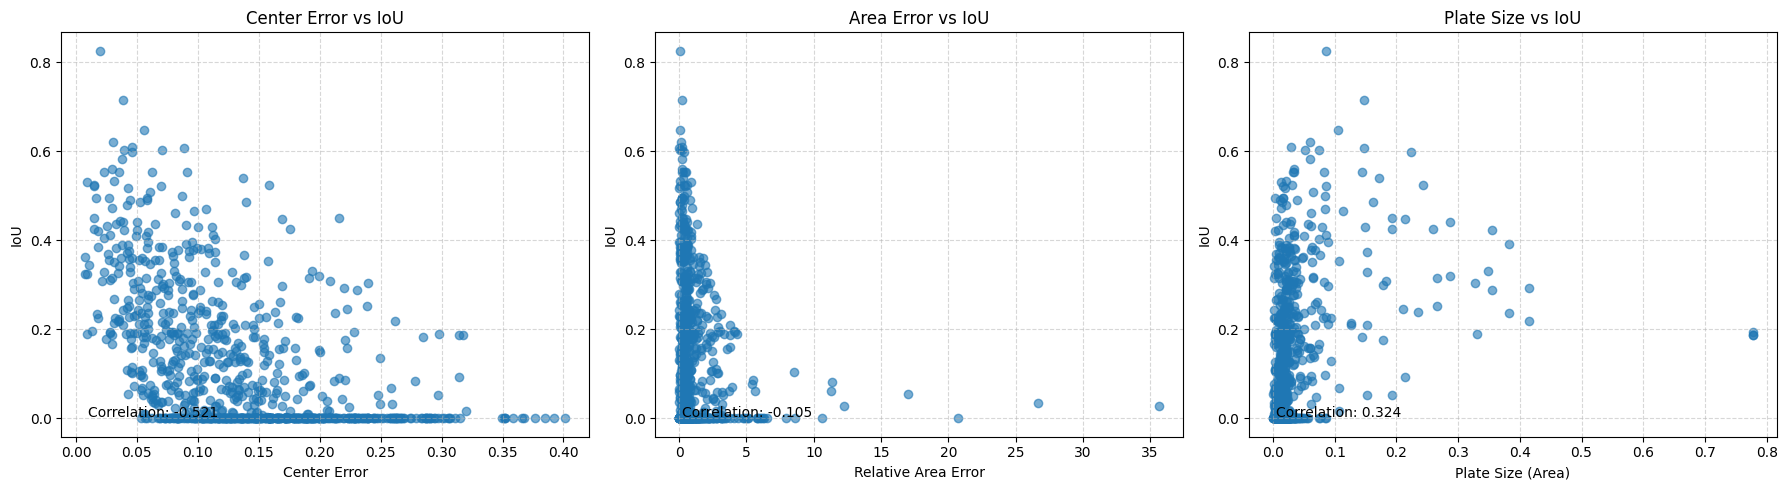

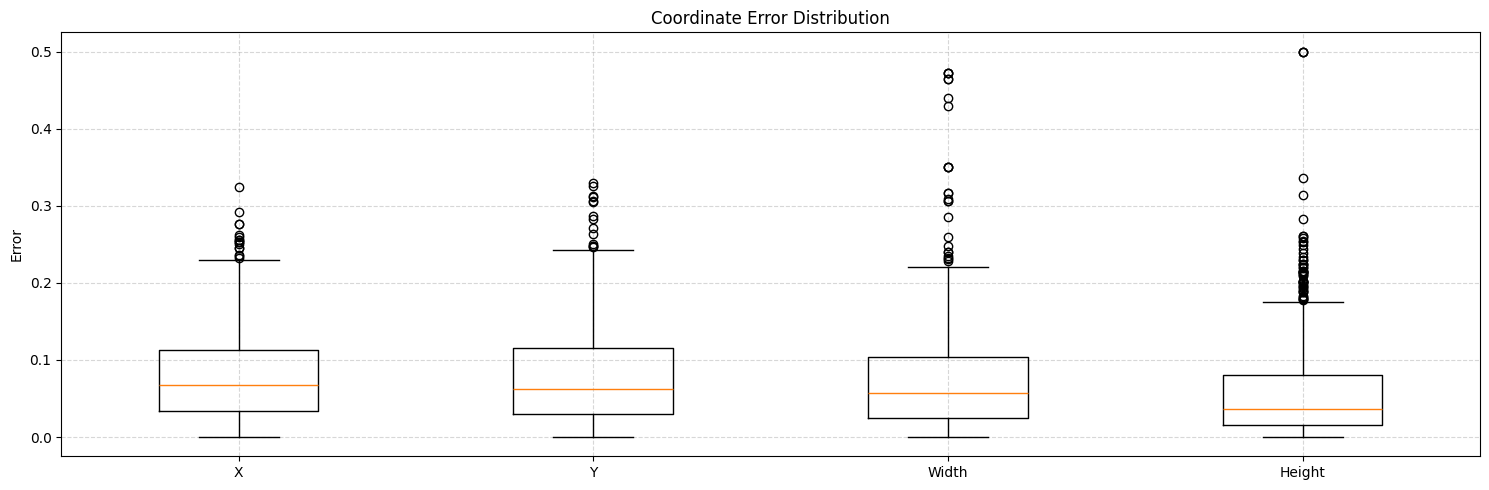


===== ERROR ANALYSIS INSIGHTS =====
1. Main source of error is in the area/size
2. Model performs worst on small license plates
6. Model performs better on larger plates

===== IMPROVEMENT RECOMMENDATIONS =====
1. Focus on improving size estimation:
   - Increase weight for width/height in the loss function
   - Consider multi-scale feature fusion techniques
   - Add size-specific regularization terms

2. General model improvements:
   - Increase training time (more epochs)
   - Add more diverse data augmentation focusing on size variations
   - Consider two-stage detection (region proposal + regression)
   - Experiment with anchor-based detection approach

3. Small plate-specific improvements:
   - Add more small plate examples through augmentation
   - Use feature pyramid networks for better small object detection
   - Consider higher resolution input images


In [ ]:
# Error analysis for advanced model
advanced_error_analysis = analyze_error_patterns(
    model=advanced_trained_model,  # Use trained model here
    X_val=X_val,
    y_val=y_val,
    y_pred=advanced_predictions,
    plate_sizes=[box[2] * box[3] for box in y_val]
)

## License Plate Detection

Finally, let's use our model to detect license plates in new images using the refactored module.

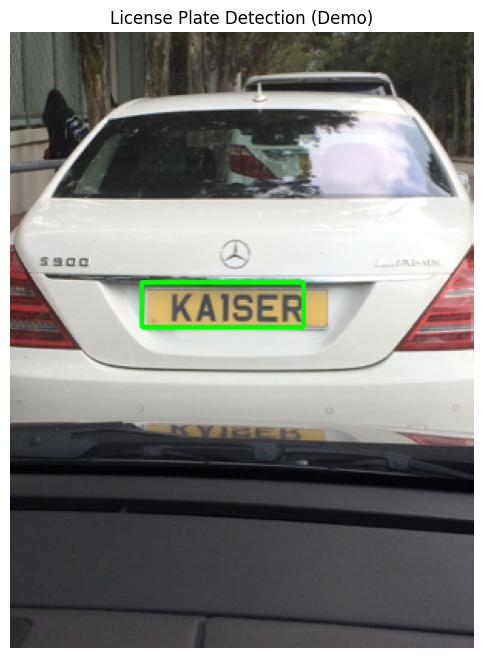

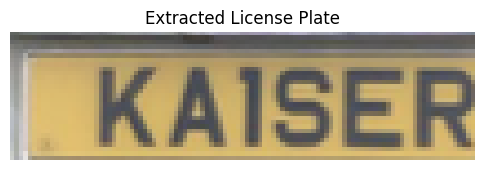

In [ ]:
# For demonstration purposes, use a sample image from our dataset
if len(df) > 0:
    sample_img_path = df.iloc[10]["image_path"]

    # In a real scenario, you would use the refactored function with a trained model
    # plate_region, bbox = detect_license_plate(sample_img_path, model, confidence_threshold=0.5)

    # For demo purposes, simulate detection
    def demo_detect_license_plate(image_path):
        """Simulate license plate detection for demonstration"""
        # Load image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img_rgb.shape[:2]

        # Get ground truth from dataset if available
        file_name = os.path.basename(image_path)
        matched_rows = df[df["image_path"].str.contains(file_name)]

        if len(matched_rows) > 0:
            # Use ground truth with small random offset
            row = matched_rows.iloc[0]
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]

            # Add some noise to simulate prediction
            noise_factor = 0.1
            x += int(np.random.normal(0, h * noise_factor))
            y += int(np.random.normal(0, h * noise_factor))
            w += int(np.random.normal(0, w * noise_factor))
            h += int(np.random.normal(0, h * noise_factor))

            # Ensure values are valid
            x = max(0, min(x, orig_w - 10))
            y = max(0, min(y, orig_h - 10))
            w = max(10, min(w, orig_w - x))
            h = max(10, min(h, orig_h - y))
        else:
            # Generate random detection
            x = int(orig_w * 0.4)
            y = int(orig_h * 0.4)
            w = int(orig_w * 0.2)
            h = int(orig_h * 0.1)

        # Draw detection on image
        result_img = img_rgb.copy()
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(result_img)
        plt.axis('off')
        plt.title("License Plate Detection (Demo)")
        plt.show()

        # Extract plate region
        plate_region = img_rgb[y:y + h, x:x + w]

        # Show extracted plate
        plt.figure(figsize=(6, 2))
        plt.imshow(plate_region)
        plt.axis('off')
        plt.title("Extracted License Plate")
        plt.show()

        return plate_region, [x, y, w, h]

    # Detect license plate in sample image
    demo_detect_license_plate(sample_img_path)
else:
    print("No images available for demonstration.")

## Recommendations for Further Improvement

To reach or surpass the IoU target of 0.7 or achieve production-level performance:

1. **Advanced Data Processing**
   - Implement adaptive image resizing based on plate size
   - Create a more balanced training dataset with more small plate examples
   - Apply stronger augmentation specifically for challenging cases

2. **Architectural Refinements**
   - Add more skip connections for enhanced gradient flow
   - Experiment with deformable convolutions for better shape modeling
   - Consider adding a confidence score branch for filtering detections

3. **Ensemble Approaches**
   - Train multiple models with different input resolutions
   - Combine predictions from YOLO and our advanced CNN
   - Create specialized models for different plate sizes

4. **Post-Processing Techniques**
   - Implement non-maximum suppression for multiple detections
   - Add bounding box refinement as a secondary step
   - Apply additional contextual constraints from domain knowledge

5. **Validation Strategy**
   - Use k-fold cross-validation for more robust evaluation
   - Test on diverse datasets to ensure generalization
   - Apply test-time augmentation for improved inference